In [472]:
# https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a
# https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
# https://www.youtube.com/watch?v=fEd1p8-3S7w&ab_channel=JonCavallieMester

In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [474]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load data

rating df

In [475]:
df_rating = pd.read_csv('ratings.csv')

In [476]:
df_rating.shape

(100836, 4)

In [477]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


movie name df

In [478]:
df_name = pd.read_csv('movies.csv')

In [479]:
df_name.shape

(9742, 3)

In [480]:
df_name.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


join both

In [481]:
df = pd.merge(df_rating, df_name, on='movieId', how='inner')

In [482]:
df = df[['userId','movieId','title','rating']]

In [483]:
df.shape

(100836, 4)

In [484]:
df.head()

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,1,3,Grumpier Old Men (1995),4.0
2,1,6,Heat (1995),4.0
3,1,47,Seven (a.k.a. Se7en) (1995),5.0
4,1,50,"Usual Suspects, The (1995)",5.0


# 2. Check data quality

data type

In [485]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   title    100836 non-null  object 
 3   rating   100836 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


unique value

In [486]:
df.shape

(100836, 4)

In [487]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  userId
Unique value:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 2

missing value

In [488]:
df.isnull().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

blank value

In [489]:
(df == '').sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

check movie id

In [490]:
movieid_counts = df.groupby('title').agg(number_movieid=('movieId', pd.Series.nunique)).reset_index()

In [491]:
multiple_movieid = movieid_counts[movieid_counts['number_movieid'] > 1]

In [492]:
multiple_movieid

,title,number_movieid
1934,Confessions of a Dangerous Mind (2002),2
2718,Emma (1996),2
2780,Eros (2004),2
7378,Saturn 3 (1980),2
9269,War of the Worlds (2005),2


In [493]:
max_movieid_df = df.groupby('title')['movieId'].max().reset_index()

In [494]:
df = pd.merge(df, max_movieid_df, on='title', how='inner')

In [495]:
df = df.rename(columns={'movieId_y': 'movieId'})

In [496]:
df = df[['userId','movieId','title','rating']]

In [497]:
df

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,1,3,Grumpier Old Men (1995),4.0
2,1,6,Heat (1995),4.0
3,1,47,Seven (a.k.a. Se7en) (1995),5.0
4,1,50,"Usual Suspects, The (1995)",5.0
...,...,...,...,...
100831,610,166534,Split (2017),4.0
100832,610,168248,John Wick: Chapter Two (2017),5.0
100833,610,168250,Get Out (2017),5.0
100834,610,168252,Logan (2017),5.0


check title

In [498]:
title_counts = df.groupby('movieId').agg(number_title=('title', pd.Series.nunique)).reset_index()

In [499]:
multiple_title = title_counts[title_counts['number_title'] > 1]

In [500]:
multiple_title

,movieId,number_title


unique value (again)

In [501]:
df.shape

(100836, 4)

In [502]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  userId
Unique value:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 2

In [503]:
df

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,1,3,Grumpier Old Men (1995),4.0
2,1,6,Heat (1995),4.0
3,1,47,Seven (a.k.a. Se7en) (1995),5.0
4,1,50,"Usual Suspects, The (1995)",5.0
...,...,...,...,...
100831,610,166534,Split (2017),4.0
100832,610,168248,John Wick: Chapter Two (2017),5.0
100833,610,168250,Get Out (2017),5.0
100834,610,168252,Logan (2017),5.0


# 3. Exploratory data analysis (EDA)

columns name

In [504]:
df.columns

Index(['userId', 'movieId', 'title', 'rating'], dtype='object')

rating max/min/distribution

In [505]:
df['rating'].max()

5.0

In [506]:
df['rating'].min()

0.5

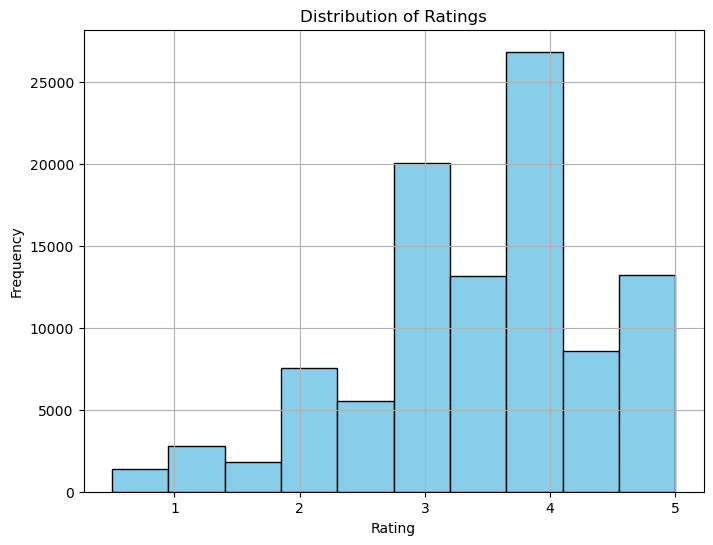

In [507]:
plt.figure(figsize=(8, 6))
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.grid(True)
plt.show()

average rating by title

In [508]:
avg_rating_by_title = df.groupby('title')['rating'].mean()

In [509]:
avg_rating_by_title_sorted = avg_rating_by_title.sort_values(ascending=False)

In [510]:
avg_rating_by_title_sorted

title
Gena the Crocodile (1969)                  5.0
True Stories (1986)                        5.0
Cosmic Scrat-tastrophe (2015)              5.0
Love and Pigeons (1985)                    5.0
Red Sorghum (Hong gao liang) (1987)        5.0
                                          ... 
Don't Look Now (1973)                      0.5
Journey 2: The Mysterious Island (2012)    0.5
Joe Dirt 2: Beautiful Loser (2015)         0.5
Jesus Christ Vampire Hunter (2001)         0.5
Fullmetal Alchemist 2018 (2017)            0.5
Name: rating, Length: 9719, dtype: float64

average rating by userId

In [511]:
avg_rating_by_userId = df.groupby('userId')['rating'].mean()

In [512]:
avg_rating_by_userId_sorted = avg_rating_by_userId.sort_values(ascending=False)

In [513]:
avg_rating_by_userId_sorted

userId
53     5.000000
251    4.869565
515    4.846154
25     4.807692
30     4.735294
         ...   
567    2.245455
153    2.217877
508    2.145833
139    2.144330
442    1.275000
Name: rating, Length: 610, dtype: float64

count userId by title

In [514]:
count_userId_by_title = df.groupby('title')['userId'].nunique()

In [515]:
count_userId_by_title_sorted = count_userId_by_title.sort_values(ascending=False)

In [516]:
count_userId_by_title_sorted

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
                                            ... 
King Solomon's Mines (1950)                    1
King Solomon's Mines (1937)                    1
King Ralph (1991)                              1
King Kong Lives (1986)                         1
À nous la liberté (Freedom for Us) (1931)      1
Name: userId, Length: 9719, dtype: int64

count title by userId

In [517]:
count_title_by_userId = df.groupby('userId')['title'].nunique()

In [518]:
count_title_by_userId_sorted = count_title_by_userId.sort_values(ascending=False)

In [519]:
count_title_by_userId_sorted

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: title, Length: 610, dtype: int64

# 4. Model - user based

pivot

In [520]:
user_item_metrix = df.pivot_table(index='userId', columns='title', values='rating')

In [521]:
user_item_metrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


mean normalize

In [522]:
# subtract by user's mean like KNNWithMean in surprise
# Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.

In [523]:
avg_rating_by_userId_sorted

userId
53     5.000000
251    4.869565
515    4.846154
25     4.807692
30     4.735294
         ...   
567    2.245455
153    2.217877
508    2.145833
139    2.144330
442    1.275000
Name: rating, Length: 610, dtype: float64

In [524]:
user_item_metrix_norm = user_item_metrix.subtract(avg_rating_by_userId_sorted, axis = 'rows')

In [525]:
user_item_metrix_norm

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.366379,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.365824,0.365824,NaN,NaN,NaN


In [526]:
user_item_metrix_norm_filled = user_item_metrix_norm.fillna(0)

In [527]:
user_item_metrix_norm_filled

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.366379,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,1.365824,0.365824,0.000000,0.000000,0.0


similarity

In [528]:
user_similarity = cosine_similarity(user_item_metrix_norm_filled)

In [529]:
user_item_metrix_norm_filled.index

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
      dtype='int64', name='userId', length=610)

In [530]:
user_similarity

array([[ 1.00000000e+00,  1.26451574e-03,  5.52577176e-04, ...,
         7.52238457e-02, -2.57125541e-02,  1.09323166e-02],
       [ 1.26451574e-03,  1.00000000e+00,  0.00000000e+00, ...,
        -6.00082818e-03, -6.00909967e-02,  2.49992083e-02],
       [ 5.52577176e-04,  0.00000000e+00,  1.00000000e+00, ...,
        -1.30006374e-02,  0.00000000e+00,  1.95499646e-02],
       ...,
       [ 7.52238457e-02, -6.00082818e-03, -1.30006374e-02, ...,
         1.00000000e+00,  5.07144903e-02,  5.44538770e-02],
       [-2.57125541e-02, -6.00909967e-02,  0.00000000e+00, ...,
         5.07144903e-02,  1.00000000e+00, -1.24714266e-02],
       [ 1.09323166e-02,  2.49992083e-02,  1.95499646e-02, ...,
         5.44538770e-02, -1.24714266e-02,  1.00000000e+00]])

In [531]:
user_similarity = pd.DataFrame(user_similarity, index=user_item_metrix_norm_filled.index, columns=user_item_metrix_norm_filled.index)

In [532]:
user_similarity

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.001265,0.000553,0.048419,0.021847,-0.045497,-0.006200,0.047013,0.019510,-0.008754,...,0.018127,-0.017172,-0.015221,-0.037059,-0.029121,0.012016,0.055261,0.075224,-0.025713,0.010932
2,0.001265,1.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011114,-0.048085,0.000000,0.003012,...,-0.050551,-0.031581,-0.001688,0.000000,0.000000,0.006226,-0.020504,-0.006001,-0.060091,0.024999
3,0.000553,0.000000,1.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.004904,-0.016117,0.017749,0.000000,-0.001431,-0.037289,-0.007789,-0.013001,0.000000,0.019550
4,0.048419,-0.017164,-0.011260,1.000000,-0.029620,0.013956,0.058091,0.002065,-0.005874,0.051590,...,-0.037687,0.063122,0.027640,-0.013782,0.040037,0.020590,0.014628,-0.037569,-0.017884,-0.000995
5,0.021847,0.021796,-0.031539,-0.029620,1.000000,0.009111,0.010117,-0.012284,0.000000,-0.033165,...,0.015964,0.012427,0.027076,0.012461,-0.036272,0.026319,0.031896,-0.001751,0.093829,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,0.006226,-0.037289,0.020590,0.026319,-0.009137,0.028326,0.022277,0.031633,-0.039946,...,0.053683,0.016384,0.098011,0.061078,0.019678,1.000000,0.017927,0.056676,0.038422,0.075464
607,0.055261,-0.020504,-0.007789,0.014628,0.031896,0.045501,0.030981,0.048822,-0.012161,-0.017656,...,0.049059,0.038197,0.049317,0.002355,-0.029381,0.017927,1.000000,0.044514,0.019049,0.021860
608,0.075224,-0.006001,-0.013001,-0.037569,-0.001751,0.021727,0.028414,0.071759,0.032783,-0.052000,...,0.069198,0.051388,0.012801,0.006319,-0.007978,0.056676,0.044514,1.000000,0.050714,0.054454


# 5. Prediction - user based

setup

In [533]:
picked_userid = 407

In [534]:
# set top similar user (k) = 10
k = 10

top similar user

In [535]:
similar_users = user_similarity[picked_userid].sort_values(ascending=False)[:k]

In [536]:
similar_users

userId
407    1.000000
30     0.223045
77     0.175024
17     0.173116
511    0.163478
439    0.156743
343    0.152849
209    0.150989
463    0.145290
86     0.138590
Name: 407, dtype: float64

unwatched movie

In [537]:
picked_userid_unwatched = user_item_metrix_norm.T[picked_userid][user_item_metrix_norm.T[picked_userid].isna()]

In [538]:
picked_userid_unwatched

title
'71 (2014)                                  NaN
'Hellboy': The Seeds of Creation (2004)     NaN
'Round Midnight (1986)                      NaN
'Salem's Lot (2004)                         NaN
'Til There Was You (1997)                   NaN
                                             ..
eXistenZ (1999)                             NaN
xXx (2002)                                  NaN
xXx: State of the Union (2005)              NaN
¡Three Amigos! (1986)                       NaN
À nous la liberté (Freedom for Us) (1931)   NaN
Name: 407, Length: 9697, dtype: float64

score

In [539]:
similar_users.index.tolist()

[407, 30, 77, 17, 511, 439, 343, 209, 463, 86]

In [540]:
len(picked_userid_unwatched.index.tolist())

9697

In [541]:
similar_user_movies = user_item_metrix_norm.loc[similar_users.index.tolist()][picked_userid_unwatched.index.tolist()]

In [542]:
similar_user_movies

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [543]:
item_list = []
item_score_list = []
item_score_predicted_list = []

In [544]:
for i in similar_user_movies.columns:
    
    sum_value_weight = 0
    sum_weight = 0
    movie_rating = similar_user_movies[i]
    for u in similar_users.index:
        if pd.isna(movie_rating[u]) == False:

            if similar_users[u] < 0:
                item_score = 0
            else:
                score = similar_users[u] * movie_rating[u]
                sum_value_weight += score
                sum_weight += similar_users[u]

    if sum_weight == 0:
        item_score = 0
    else:
        item_score = sum_value_weight/sum_weight

    item_list.append(i)
    item_score_list.append(item_score)
    item_score_predicted_list.append(item_score + avg_rating_by_userId_sorted[picked_userid])

In [545]:
df_user_base_predict = pd.DataFrame({
    'user': [picked_userid]*len(item_list),
    'title': item_list,
    'ranking': item_score_list,
    'ranking_predicted':item_score_predicted_list
})

In [546]:
df_user_base_predict.sort_values(by='ranking', ascending=False).head(5)

,user,title,ranking,ranking_predicted
5818,407,Mr. & Mrs. Smith (2005),1.071429,5.185065
7905,407,Spider-Man 2 (2004),1.000000,5.113636
3781,407,Harry Potter and the Chamber of Secrets (2002),1.000000,5.113636
4774,407,"King of Kong, The (2007)",0.940678,5.054314
8148,407,Sunshine (2007),0.940678,5.054314


In [547]:
df_user_base_predict.sort_values(by='ranking_predicted', ascending=False).head(5)

,user,title,ranking,ranking_predicted
5818,407,Mr. & Mrs. Smith (2005),1.071429,5.185065
7905,407,Spider-Man 2 (2004),1.000000,5.113636
3781,407,Harry Potter and the Chamber of Secrets (2002),1.000000,5.113636
4774,407,"King of Kong, The (2007)",0.940678,5.054314
8148,407,Sunshine (2007),0.940678,5.054314


# 6. Model - item based

pivot

In [548]:
item_user_metrix = df.pivot_table(index='title', columns='userId', values='rating')

In [549]:
item_user_metrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


mean normalize

In [550]:
# subtract by movie's mean like KNNWithMean in surprise

In [551]:
avg_rating_by_title_sorted

title
Gena the Crocodile (1969)                  5.0
True Stories (1986)                        5.0
Cosmic Scrat-tastrophe (2015)              5.0
Love and Pigeons (1985)                    5.0
Red Sorghum (Hong gao liang) (1987)        5.0
                                          ... 
Don't Look Now (1973)                      0.5
Journey 2: The Mysterious Island (2012)    0.5
Joe Dirt 2: Beautiful Loser (2015)         0.5
Jesus Christ Vampire Hunter (2001)         0.5
Fullmetal Alchemist 2018 (2017)            0.5
Name: rating, Length: 9719, dtype: float64

In [552]:
item_user_metrix_norm = item_user_metrix.subtract(avg_rating_by_title_sorted, axis = 'rows')

In [553]:
item_user_metrix_norm

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.136364,NaN,NaN,NaN,NaN,0.636364,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.770833,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.729167,NaN,-0.770833
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.500000


In [554]:
item_user_metrix_norm_filled = item_user_metrix_norm.fillna(0)

similarity

In [555]:
item_user_metrix_norm_filled

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Round Midnight (1986),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Salem's Lot (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Til There Was You (1997),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.136364,0.0,0.0,0.0,0.0,0.636364,0.0,0.000000
xXx (2002),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.770833,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.729167,0.0,-0.770833
xXx: State of the Union (2005),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-0.500000


In [556]:
item_similarity = cosine_similarity(item_user_metrix_norm_filled)

In [557]:
item_user_metrix_norm_filled.index

Index([''71 (2014)', ''Hellboy': The Seeds of Creation (2004)',
       ''Round Midnight (1986)', ''Salem's Lot (2004)',
       ''Til There Was You (1997)', ''Tis the Season for Love (2015)',
       ''burbs, The (1989)', ''night Mother (1986)',
       '(500) Days of Summer (2009)', '*batteries not included (1987)',
       ...
       'Zulu (2013)', '[REC] (2007)', '[REC]² (2009)',
       '[REC]³ 3 Génesis (2012)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'eXistenZ (1999)', 'xXx (2002)', 'xXx: State of the Union (2005)',
       '¡Three Amigos! (1986)', 'À nous la liberté (Freedom for Us) (1931)'],
      dtype='object', name='title', length=9719)

In [558]:
item_similarity

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [559]:
item_similarity = pd.DataFrame(item_similarity, index=item_user_metrix_norm_filled.index, columns=item_user_metrix_norm_filled.index)

In [560]:
item_similarity

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.060699,0.0,-0.075277,0.029474,...,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.037846,0.00000,-0.034109,0.0
xXx (2002),0.0,0.0,0.0,0.0,0.0,0.0,-0.003527,0.0,0.155888,0.251118,...,0.0,-0.206757,-0.004854,0.0,0.0,0.037846,1.000000,0.24493,0.018548,0.0
xXx: State of the Union (2005),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.110782,0.000000,...,0.0,-0.201402,0.077152,0.0,0.0,0.000000,0.244930,1.00000,0.000000,0.0


In [561]:
# diagonal is zero due to all zero in the movie

# 7. Prediction - user based

setup

In [562]:
picked_userid = 407

In [563]:
# set top similar item (k) = 10\
k = 10

top similar user

In [564]:
similar_users = user_similarity[picked_userid].sort_values(ascending=False)[:k]

In [565]:
similar_users

userId
407    1.000000
30     0.223045
77     0.175024
17     0.173116
511    0.163478
439    0.156743
343    0.152849
209    0.150989
463    0.145290
86     0.138590
Name: 407, dtype: float64

unwatched movie

In [566]:
picked_userid_unwatched = user_item_metrix_norm.T[picked_userid][user_item_metrix_norm.T[picked_userid].isna()]

In [567]:
picked_userid_unwatched

title
'71 (2014)                                  NaN
'Hellboy': The Seeds of Creation (2004)     NaN
'Round Midnight (1986)                      NaN
'Salem's Lot (2004)                         NaN
'Til There Was You (1997)                   NaN
                                             ..
eXistenZ (1999)                             NaN
xXx (2002)                                  NaN
xXx: State of the Union (2005)              NaN
¡Three Amigos! (1986)                       NaN
À nous la liberté (Freedom for Us) (1931)   NaN
Name: 407, Length: 9697, dtype: float64

watched movie

In [568]:
picked_title_watched = user_item_metrix_norm.T[picked_userid][user_item_metrix_norm.T[picked_userid].notna()]

In [569]:
picked_title_watched

title
Bourne Ultimatum, The (2007)                                     -0.613636
Dark Knight, The (2008)                                           0.886364
Die Hard (1988)                                                  -1.113636
Fight Club (1999)                                                 0.886364
Gone Girl (2014)                                                  0.886364
Grand Budapest Hotel, The (2014)                                 -0.613636
How to Train Your Dragon (2010)                                  -0.113636
Indiana Jones and the Last Crusade (1989)                        -0.113636
Iron Man (2008)                                                   0.886364
Lord of the Rings: The Fellowship of the Ring, The (2001)         0.886364
Lord of the Rings: The Return of the King, The (2003)             0.886364
Lord of the Rings: The Two Towers, The (2002)                     0.886364
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)   -1.113636
Matrix, The (1999) 

In [570]:
watched_list = picked_title_watched.index.tolist()

In [571]:
item_similarity['Zulu (2013)'].loc[watched_list].sort_values(ascending=False).head(k)

title
Bourne Ultimatum, The (2007)                                     0.0
Dark Knight, The (2008)                                          0.0
Up (2009)                                                        0.0
Terminator, The (1984)                                           0.0
Star Wars: Episode V - The Empire Strikes Back (1980)            0.0
Star Wars: Episode IV - A New Hope (1977)                        0.0
Saving Private Ryan (1998)                                       0.0
Pirates of the Caribbean: The Curse of the Black Pearl (2003)    0.0
Minority Report (2002)                                           0.0
Matrix, The (1999)                                               0.0
Name: Zulu (2013), dtype: float64

In [572]:
item_list = []
item_score_list = []
item_score_predicted_list = []

score

In [573]:
for i in picked_userid_unwatched.index.tolist():

    watched_list = picked_title_watched.index.tolist()

    similarity_rank = item_similarity[i].loc[watched_list].sort_values(ascending=False).head(k)
    rating_rank = picked_title_watched[similarity_rank.index.tolist()]

    for j in similarity_rank.index.tolist():
        if similarity_rank[j] < 0:
            item_score = 0
        else:
            sum_value_weight += similarity_rank[j] * rating_rank[j]
            sum_weight += similarity_rank[j]            
        
    if sum_weight == 0:
        item_score = 0
    else:
        item_score = sum_value_weight/sum_weight

    item_list.append(i)
    item_score_list.append(item_score)
    item_score_predicted_list.append(item_score + avg_rating_by_title_sorted[i])

In [574]:
df_item_base_predict = pd.DataFrame({
    'user': [picked_userid]*len(item_list),
    'title': item_list,
    'ranking': item_score_list,
    'ranking_predicted':item_score_predicted_list
})

In [575]:
df_item_base_predict.sort_values(by='ranking', ascending=False).head(5)

,user,title,ranking,ranking_predicted
22,407,100 Streets (2016),0.080724,2.580724
21,407,100 Girls (2000),0.080724,3.330724
20,407,"10,000 BC (2008)",0.076701,2.782584
19,407,10 Years (2011),0.059539,3.559539
18,407,10 Things I Hate About You (1999),0.059539,3.587317


In [576]:
df_item_base_predict.sort_values(by='ranking_predicted', ascending=False).head(5)

,user,title,ranking,ranking_predicted
131,407,61* (2001),0.027674,5.027674
158,407,A Flintstones Christmas Carol (1994),0.027669,5.027669
148,407,9/11 (2002),0.027669,5.027669
156,407,A Detective Story (2003),0.027669,5.027669
167,407,A Perfect Day (2015),0.027470,5.027470


# 8. Hybrid recommendation

In [577]:
df_user_base_predict

,user,title,ranking,ranking_predicted
0,407,'71 (2014),0.0,4.113636
1,407,'Hellboy': The Seeds of Creation (2004),0.0,4.113636
2,407,'Round Midnight (1986),0.0,4.113636
3,407,'Salem's Lot (2004),0.0,4.113636
4,407,'Til There Was You (1997),0.0,4.113636
...,...,...,...,...
9692,407,eXistenZ (1999),0.0,4.113636
9693,407,xXx (2002),0.0,4.113636
9694,407,xXx: State of the Union (2005),0.0,4.113636
9695,407,¡Three Amigos! (1986),0.0,4.113636


In [578]:
df_item_base_predict

,user,title,ranking,ranking_predicted
0,407,'71 (2014),0.000000,4.000000
1,407,'Hellboy': The Seeds of Creation (2004),0.000000,4.000000
2,407,'Round Midnight (1986),0.000000,3.500000
3,407,'Salem's Lot (2004),0.000000,5.000000
4,407,'Til There Was You (1997),-0.113636,3.886364
...,...,...,...,...
9692,407,eXistenZ (1999),-0.018565,3.845072
9693,407,xXx (2002),-0.018594,2.752240
9694,407,xXx: State of the Union (2005),-0.018601,1.981399
9695,407,¡Three Amigos! (1986),-0.018601,3.116014


In [579]:
full_recsys = pd.merge(df_user_base_predict,df_item_base_predict, on = ['user','title'], how = 'inner')

In [580]:
full_recsys['final_score'] = full_recsys['ranking_predicted_x']*0.7 + full_recsys['ranking_predicted_y']*0.3

In [581]:
full_recsys

,user,title,ranking_x,ranking_predicted_x,ranking_y,ranking_predicted_y,final_score
0,407,'71 (2014),0.0,4.113636,0.000000,4.000000,4.079545
1,407,'Hellboy': The Seeds of Creation (2004),0.0,4.113636,0.000000,4.000000,4.079545
2,407,'Round Midnight (1986),0.0,4.113636,0.000000,3.500000,3.929545
3,407,'Salem's Lot (2004),0.0,4.113636,0.000000,5.000000,4.379545
4,407,'Til There Was You (1997),0.0,4.113636,-0.113636,3.886364,4.045455
...,...,...,...,...,...,...,...
9692,407,eXistenZ (1999),0.0,4.113636,-0.018565,3.845072,4.033067
9693,407,xXx (2002),0.0,4.113636,-0.018594,2.752240,3.705217
9694,407,xXx: State of the Union (2005),0.0,4.113636,-0.018601,1.981399,3.473965
9695,407,¡Three Amigos! (1986),0.0,4.113636,-0.018601,3.116014,3.814350


In [582]:
full_recsys = full_recsys[['user','title','final_score']]

In [583]:
full_recsys.sort_values(by = 'final_score', ascending=False)

,user,title,final_score
4344,407,Infernal Affairs (Mou gaan dou) (2002),4.832550
3594,407,Grave of the Fireflies (Hotaru no haka) (1988),4.780425
627,407,Assassination of Jesse James by the Coward Rob...,4.766165
7905,407,Spider-Man 2 (2004),4.714052
4774,407,"King of Kong, The (2007)",4.707461
...,...,...,...
1682,407,Charlie's Angels (2000),2.440958
591,407,Armageddon (1998),2.312768
104,407,300 (2007),2.295466
5285,407,Lupin III: The Castle Of Cagliostro (Rupan san...,2.101877
